# Convolutional and Recurrent Neural Networks

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
import os.path
import subprocess
import matplotlib.collections
import scipy.signal
from sklearn import model_selection
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Use CPU rather than GPU for keras neural networks
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""
from tensorflow import keras
from tqdm.keras import TqdmCallback




In [3]:
import tensorflow as tf
tf.compat.v1.enable_v2_behavior()      # ensure TF2 behavior
tf.config.run_functions_eagerly(True)  # optional, makes debugging easier


## <span style="color:Orange">Recurrent Networks</span>

All the architectures we have seen so far are **feed-foward** networks, with input data always from left (input layer) to right (output layer). A <span style="color:Violet">recurrent neural network</span> (RNN) adds links that feed back into a previous layer. This simple modification adds significant complexity but also expressive power (comparable to the electronics revolution associated with the idea of transistor feedback).

Architectures with feedback are still maturing but some useful building blocks have emerged, such as the [long short-term memory unit](https://en.wikipedia.org/wiki/Long_short-term_memory), which allows a network to remember some internal state but also forget it based on new input.

Some practical considerations for RNN designs:
 - The order of training data is now significant and defines a "model time", but the network can be reset whenever needed.

 - Input data can be packaged into variable-length messages that generate variable (and different) length output messages. This is exactly what language translation needs.

 - Optimization of the weights using gradients is still possible but requires "unrolling" the network by cloning it enough times to process the longest allowed messages.

A feed-foward network implements a universal approximating function. Since the internal state of an RNN acts like local variables, you can think of an RNN as a universal approximating program.

See this [blog post](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) for an example based on natural language synthesis.

A "recurrent" neural network is not exactly feedforward.
There are a variety of forms for a recurrent network, but using the previous diagramming method, we can write the most common form as:

![](https://raw.githubusercontent.com/GDS-Education-Community-of-Practice/DSECOP/main/Time_Series_Analysis_and_Forecasting/diagrams/recurrent_nn_loop.drawio.svg)

As you can see, there is a loop (the recurrent part) which passes information from one evaluation of the function to the next time the function is evaluated.
This might seem strange at first glance but makes more sense when you consider a sequence of events.
For example, words.
If we have three words of a sentence, predicting the next word likely depends on all three words rather than only the previous.

### <span style="color:LightGreen">Stucture</span>

The "looped" diagram shown above can also be written in an "unrolled" form as follows:

___<span style="color:Tan">Many-to-many</span>___

![](https://raw.githubusercontent.com/GDS-Education-Community-of-Practice/DSECOP/main/Time_Series_Analysis_and_Forecasting/diagrams/recurrent_nn1.drawio.svg)

Note that this form of recurrent neural network requires inputs at each step and gives outputs at each step.
This is is not strictly necessary and you could instead have only the end output or only one input and one output as show below:

___<span style="color:Tan">Many-to-one</span>___
![](https://raw.githubusercontent.com/GDS-Education-Community-of-Practice/DSECOP/main/Time_Series_Analysis_and_Forecasting/diagrams/recurrent_nn2.drawio.svg)

___<span style="color:Tan">One-to-one</span>___
![](https://raw.githubusercontent.com/GDS-Education-Community-of-Practice/DSECOP/main/Time_Series_Analysis_and_Forecasting/diagrams/recurrent_nn3.drawio.svg)


Each of the demonstrated diagrams features a very simple version of the neural network, but it could have many layers at each step such as the following:

![](https://raw.githubusercontent.com/GDS-Education-Community-of-Practice/DSECOP/main/Time_Series_Analysis_and_Forecasting/diagrams/recurrent_nn_loop2.drawio.svg)

Fortunately, these can all be easily implemented using the `keras` framework.
Let's return to our example of input data of the form $[\sin(t),\cos(t)]$ and outputs of the form $\sin(t)\cos(t)$ but lets try to use 2 values of $t$ to get the next value.
So, we will pass in something like

$$ \Large
\begin{bmatrix}
\sin(t_1) & \cos(t_1) \\
\sin(t_2) & \cos(t_2)
\end{bmatrix}
$$

to get the output $\sin(t_3)\cos(t_3)$.
We'll use two layers.
See below for examples of these recurrent neural network forms:

In [4]:
keras.utils.set_random_seed(0)

# Make input layer of appropriate size (2 samples of size 2 or 1 sample of size 2)
x_many   = keras.layers.Input(shape=(2,2))
x_one    = keras.layers.Input(shape=(1,2))

# Pass input x into first layer of size 3 x 2
# return_sequences=True means there is an output for each input
y_many = keras.layers.SimpleRNN(3,activation="tanh", return_sequences=True)(x_many)
y_one  = keras.layers.SimpleRNN(3,activation="tanh", return_sequences=True)(x_one)
y_many_to_many = keras.layers.SimpleRNN(1,activation="tanh", return_sequences=True)(y_many)
y_many_to_one  = keras.layers.SimpleRNN(1,activation="tanh", return_sequences=False)(y_many)
y_one_to_one   = keras.layers.SimpleRNN(1,activation="tanh", return_sequences=False)(y_one)

many_to_many = keras.Model(inputs=x_many,outputs=y_many_to_many)
many_to_one  = keras.Model(inputs=x_many,outputs=y_many_to_one)
one_to_one   = keras.Model(inputs=x_one ,outputs=y_one_to_one)

In [5]:
# 1 batch of 2 random samples of size 2
sample_many = np.random.random(size=(1,2,2))
sample_one  = np.random.random(size=(1,1,2))

print("Sample of 2: \n{}".format(sample_many))
print("Many to many output: \n{}".format(many_to_many(sample_many)))
print("Many to one output: \n{}".format(many_to_one(sample_many)))
print("Sample of 1: \n{}".format(sample_one))
print("One to one output: \n{}".format(one_to_one(sample_one)))

Sample of 2: 
[[[0.5488135  0.71518937]
  [0.60276338 0.54488318]]]
Many to many output: 
[[[-0.55528486]
  [ 0.16151634]]]
Many to one output: 
[[0.2607466]]
Sample of 1: 
[[[0.4236548  0.64589411]]]
One to one output: 
[[-0.40512717]]


The number passed into the `SimpleRNN` is the number of loops performed.
In the case described above, we want to take samples at times $t_1$ and $t_2$ and output the value of the function at time $t_3$.
This is a "many-to-one" case.

In order to train the network to perform well in this case, we need to arrange our data in pairs of

$$ \Large
\begin{bmatrix}
\sin(t_i) & \cos(t_{i}) \\
\sin(t_{i+1}) & \cos(t_{i+1})
\end{bmatrix}
$$

aligned with outputs $\sin(t_{i+2})\cos(t_{i+2})$:

In [6]:
# Make our data samples
t_values = np.linspace(0,10,100)
samples = np.vstack([np.sin(t_values), np.cos(t_values)]).T
output_values = np.sin(t_values)*np.cos(t_values)

# Arrange our data samples
input_samples = []
output_samples = []
for i in range(98):
  # Take two samples at time t_i and t_{i+1}
  input_samples.append(samples[i:i+2])
  # Get function output at time t_{i+2}
  output_samples.append(output_values[i+2])

input_samples = np.array(input_samples)
output_samples = np.array(output_samples)

We can now compile the many to one model and train it on this test data.

0epoch [00:00, ?epoch/s]

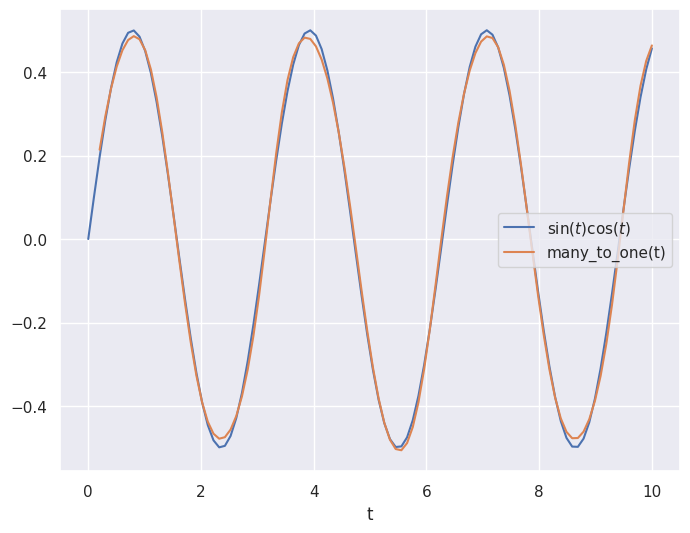

In [7]:
# Train model
many_to_one.compile(
    optimizer = keras.optimizers.Adam(),
    loss = keras.losses.MeanSquaredError()
)
history = many_to_one.fit(
    input_samples,
    output_samples,
    batch_size=10,         # The training takes groups of samples (in this case 10 samples at a time)
    epochs=500,            # The number of times to iterate through our dataset
    validation_split = 0.2,# Use 20% of data to check accuracy
    verbose=0,             # Don't print info as it trains
    callbacks=[TqdmCallback(verbose=0)]
)

# Plot prediction and the true values
plt.close('all')
plt.figure(figsize=(8,6))
plt.plot(t_values, output_values, label="$\sin(t)\cos(t)$")
plt.plot(t_values[2:], many_to_one(input_samples), label="many_to_one(t)")
plt.legend()
plt.xlabel("t")
plt.show()

Similar to the feedforward neural network, the recurrent architecture was able to roughly approximate the curve!
Although it is not very noticeable in this case, the recurrent model can also uses less weights and biases (because it has the looping behavior built in) making it less computationally expensive and easier to train!
This has made the recurrent architecture very popular for time series like applications for real world problems (in fact, modern transformers such as ChatGPT are built on the same concepts as RNNs).

## <span style="color:Orange">Convolutional Networks</span>

A _<span style="color:Violet">Convolutional Neural Network</span>_ (CNN) is a special architecture that:
 - Assumes that input features measure some property on a grid. The grid is usually spatial or temporal, but this is not required. For example, a 1D spectrum or time series, a 2D monochrome image, or a 3D stack of 2D images in different filters (RGB, etc).

 - Performs translation-invariant learning efficiently. For example, identifying a galaxy wherever it appears in an image, or a transient pulse wherever it appears in a time series. The main efficiency is a much reduced number of parameters compared to the number of input features, relative to the dense fully connected networks we have seen so far.

As we saw in the previous lecture, Neural Networks receive an input (a single vector), and transform it through a series of hidden layers. Each hidden layer is made up of a set of neurons, where each neuron is fully connected to all neurons in the previous layer, and where neurons in a single layer function completely independently and do not share any connections. The last fully-connected layer is called the “output layer” and in classification settings it represents the class scores.

The fully-connected, feed-forward neural networks we have studied thus far do not scale well to large image data. For example, a modest 200 $\times$ 200 $\times$ 3 (x-pixels, y-pixels, 3 colors) image would lead to neurons that have 200 $\times$ 200 $\times$ 3 = 120,000 weights. Moreover, we would almost certainly want to have several such neurons, so the parameters would add up quickly! Clearly, this full connectivity is wasteful and the huge number of parameters would quickly lead to overfitting.

Convolutional Neural Networks take advantage of the fact that the input consists of images and they constrain the architecture in a more sensible way to reduce the number of parameters. In particular, unlike a regular Neural Network, the layers of a CNN have neurons arranged in 3 dimensions: width, height, depth.

(Note that the word "depth" here refers to the third dimension of an activation volume, not to the depth of a full Neural Network, which can refer to the total number of layers in a network...)

The neurons in a CNN layer will only be connected to a small region of the layer before it, instead of all of the neurons in a fully-connected manner.

A CNN is made up of layers of different types (convolutions, pooling, fully-connected), in general. Every layer has a simple API: It transforms an input 3D volume to an output 3D volume with some differentiable function that may or may not have parameters.

We will use the following problem to motivate and demonstration a CNN:

 - The input data consists of triplets of digitized waveforms.

 - Each waveform has a slowly varying level with some narrow pulses superimposed.

 - Each triplet has a single pulse that is synchronized (coincident) in all three waveforms.

 - Waveforms also contain a random number of unsynchronized "background" pulses.

 - Synchronized and unsynchronized pulses can overlap in time and between traces.

The goal is to identify the location of the synchronized pulses in each triplet. This is a simplified version of a common task in data acquisition trigger systems and transient analysis pipelines.

In [8]:
def generate(N=10000, ntrace=3, nt=100, nbg=1., A=5., nsmooth=3, T=1., seed=123):
    gen = np.random.RandomState(seed=seed)
    t_grid = np.linspace(0., T, nt)
    # Generate the smooth background shapes as superpositions of random cosines.
    wlen = 2 * T * gen.lognormal(mean=0., sigma=0.2, size=(nsmooth, N, ntrace, 1))
    phase = gen.uniform(size=wlen.shape)
    X = np.cos(2 * np.pi * (t_grid + phase * wlen) / wlen).sum(axis=0)
    # Superimpose short pulses.
    sigma = 0.02 * T
    tsig = T * gen.uniform(0.05, 0.95, size=N)
    y = np.empty(N, dtype=int)
    nbg = gen.poisson(lam=nbg, size=(N, ntrace))
    for i in range(N):
        # Add a coincident pulse to all traces.
        xsig = A * np.exp(-0.5 * (t_grid - tsig[i]) ** 2 / sigma ** 2)
        y[i] = np.argmax(xsig)
        X[i] += xsig
        # Add non-coincident background pulses to each trace.
        for j in range(ntrace):
            if nbg[i, j] > 0:
                t0 = T * gen.uniform(size=(nbg[i, j], 1))
                X[i, j] += (A * np.exp(-0.5 * (t_grid - t0) ** 2 / sigma ** 2)).sum(axis=0)
    return X.astype(np.float32), y

X, y = generate()

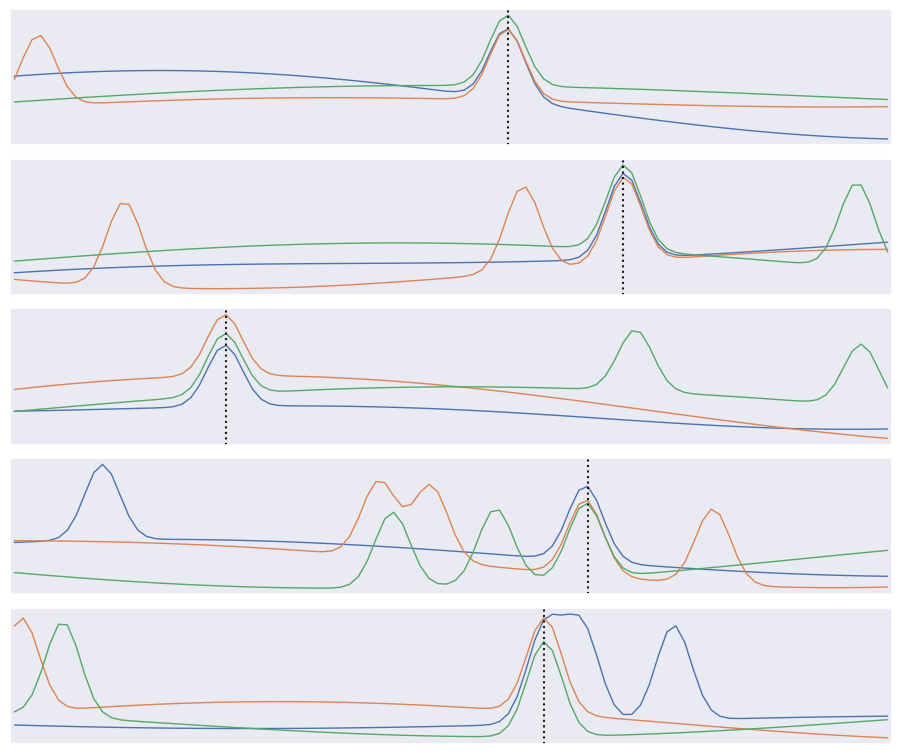

In [9]:
def plot_traces(X, y):
    Nsample, Ntrace, D = X.shape
    _, ax = plt.subplots(Nsample, 1, figsize=(9, 1.5 * Nsample))
    t = np.linspace(0., 1., 100)
    dt = t[1] - t[0]
    for i in range(Nsample):
        for j in range(Ntrace):
            ax[i].plot(t, X[i, j], lw=1)
        ax[i].axvline(t[y[i]], c='k', ls=':')
        ax[i].set_yticks([])
        ax[i].set_xticks([])
        ax[i].set_xlim(-0.5 * dt, 1 + 0.5 * dt)
    plt.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.99, hspace=0.1)

plot_traces(X[:5], y[:5])

The derivative of $f(x)$ can be approximated as

$$ \Large
f'(x) \simeq \frac{f(x + \delta) - f(x - \delta)}{2\delta}
$$

for small $\delta$. We can use this approximation to convert an array of $f(n \Delta x)$ values into an array of estimated $f'(n \Delta x)$ values using:
```
K = np.array([-1, 0, +1]) / ( 2 * dx)
fp[0] = K.dot(f[[0,1,2]])
fp[1] = K.dot(f[[1,2,3]])
...
fp[N-2] = K.dot(f[[N-3,N-2,N-1]]
```
The numpy [convolve function](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.convolve.html) automates this process of sliding an arbitrary <span style="color:Violet">kernel</span> $K$ along an input array like this. The result only estimates a first (or higher-order) derivative when the kernel contains [special values](https://en.wikipedia.org/wiki/Finite_difference_coefficient) (and you should normally use the numpy [gradient function](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.gradient.html) for this), but any convolution is a valid and potentially useful transformation.

A clarifying word about terminology: In the context of convolutional networks, <span style="color:Violet">kernel</span> is a simple group of weights shared all over the input space that is engineered to determine what specific features are to be detected. The kernel is also sometimes referred to as a "feature map" or "filter" in this context.

See for example the application of a kernel in convolution over a simple black-and-white image:
[here](https://i.stack.imgur.com/9Iu89.gif).


The kernel needs to completely overlap the input array it is being convolved with, which means that the output array is smaller and offset. Alternatively, you can pad the input array with zeros to extend the output array. There are three different conventions for handling these edge effects via the `mode` parameter to `np.convolve`:
 - **valid**: no zero padding, so output length is $N - K + 1$ and offset is $(K-1)/2$.

 - **same**: apply zero padding and trim so output length equals input length $N$, and offset is zero.

 - **full**: apply zero padding without trimming, so output length is $N + K - 1$ and offset is $-(K-1)/2$.

(Here $N$ and $K$ are the input and kernel lengths, respectively).

We can use a convolution to identify features in our input data:

In [10]:
def plot_convolved(x, kernel, smax=50):
    t = np.arange(len(x))
    plt.plot(t, x, lw=1, c='gray')
    z = np.convolve(x, kernel, mode='same')
    for sel, c in zip(((z > 0), (z < 0)), 'rb'):
        plt.scatter(t[sel], x[sel], c=c, s=smax * np.abs(z[sel]), lw=0)
    plt.gca()
    plt.grid(False)

First, let's pick out regions of large positive (red) or negative slope (notice how the edge padding causes some artifacts):

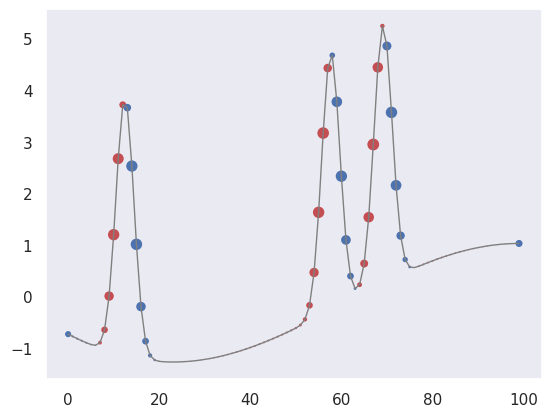

In [11]:
plot_convolved(X[1, 1], [0.5,0,-0.5])

We can also pick out regions of large curvature (using the finite-difference coefficients for a second derivative):

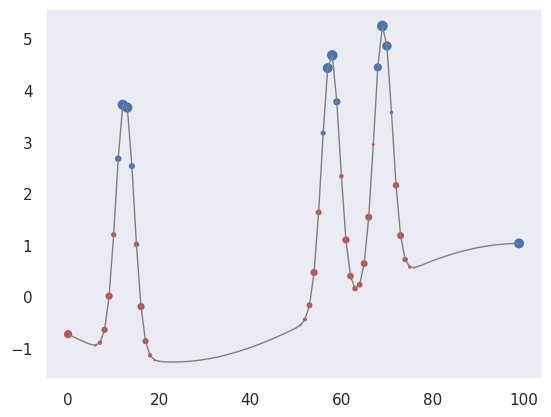

In [12]:
plot_convolved(X[1, 1], [1.,-2.,1.])

We can apply both of these convolutions to transform our input data to a new representation that highlights regions of large first or second derivative. Use a `tanh` activation to accentuate the effect:

In [13]:
def apply_convolutions(X, *kernels):
    N1, N2, D = X.shape
    print(X.shape)
    out = []
    for i in range(N1):
        sample = []
        for j in range(N2):
            for K in kernels:
                sample.append(np.tanh(np.convolve(X[i, j], K, mode='valid')))
        out.append(sample)
    return np.asarray(out)

In [14]:
out = apply_convolutions(X, [0.5,0,-0.5], [1.,-2.,1.])
print(out.shape)

(10000, 3, 100)
(10000, 6, 98)


The resulting array can be viewed as a synthetic image and offers an easy way to visually identify individual narrow peaks and their correlations between traces:

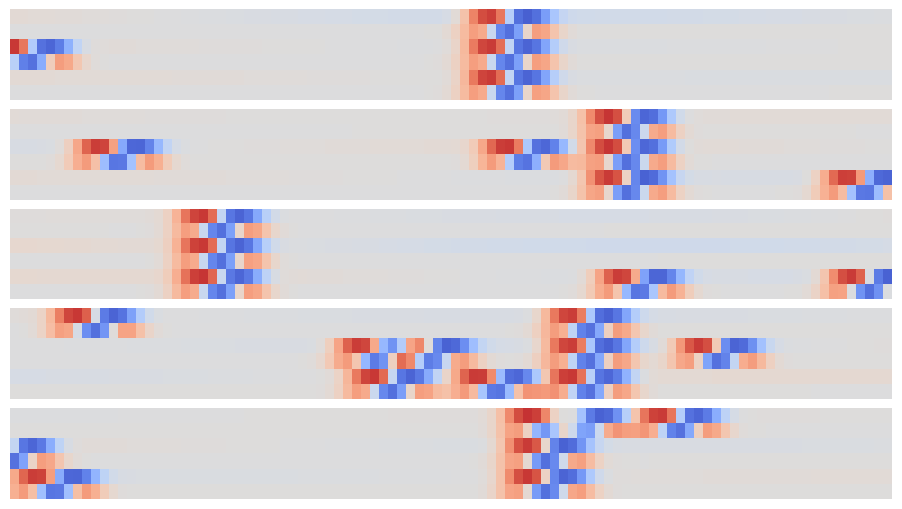

In [15]:
def plot_synthetic(Z):
    _, ax = plt.subplots(len(Z), 1, figsize=(9, len(Z)))
    for i, z in enumerate(Z):
        ax[i].imshow(z, aspect='auto', origin='upper', interpolation='none',
                   cmap='coolwarm', vmin=-1, vmax=+1);
        ax[i].grid(False)
        ax[i].axis('off')
    plt.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.99, hspace=0.1)

plot_synthetic(out[:5])

The patterns that identify individual and coincident peaks are all translation invariant so can be identified in this array using a new convolution, but now in the 2D space of these synthetic images.

Since matrix convolution is a linear operation, it is a special case of our general neural network unit,

$$ \Large
\mathbf{f}(\mathbf{x}) = W\mathbf{x} + \mathbf{b} \; ,
$$

but with the matrix $W$ now having many repeated elements so its effective number of dimensions is greatly reduced in typical applications.

A <span style="color:Violet">convolutional layer</span> takes an arbitrary input array and applies a number of filters with the same shape in parallel. By default, the filter kernels march with single-element steps through the input array, but you can also specify larger <span style="color:Violet">stride vector</span>.

In the general case, the input array, kernels and stride vector are all multidimensional, but with the same dimension. Tensorflow provides convenience functions for 1D, 2D and 3D convolutional layers, for example:
```
hidden = tf.layers.Conv2D(
    filters=3, kernel_size=[4, 5], strides=[2, 1],
    padding='same', activation=tf.nn.relu)
```
Note that `padding` specifies how edges effects are handled, but only `same` and `valid` are supported (and `valid` is the default). You can also implement higher-dimensional convolutional layers using the lower-level APIs.

A _<span style="color:Violet">convolutional neural network</span>_ (CNN) is a network containing convolutional layers. A typical architecture starts with convolutional layers, processing the input, then finishes with some fully connected dense layers to calculate the output. Since one of the goals of a CNN is reduce the number of parameters, a CNN often also incorporates [pooling layers](https://en.wikipedia.org/wiki/Convolutional_neural_network#Pooling_layer) to reduce the size of the array fed to to later layers by "downsampling" (typically using a maximum or mean value). See [these Stanford CS231n notes](http://cs231n.github.io/convolutional-networks/) for more details in the context of image classification.

In [16]:
!rm -rf tfs/pulses

{'acc': 0.9472500085830688, 'loss': 0.14754460752010345}


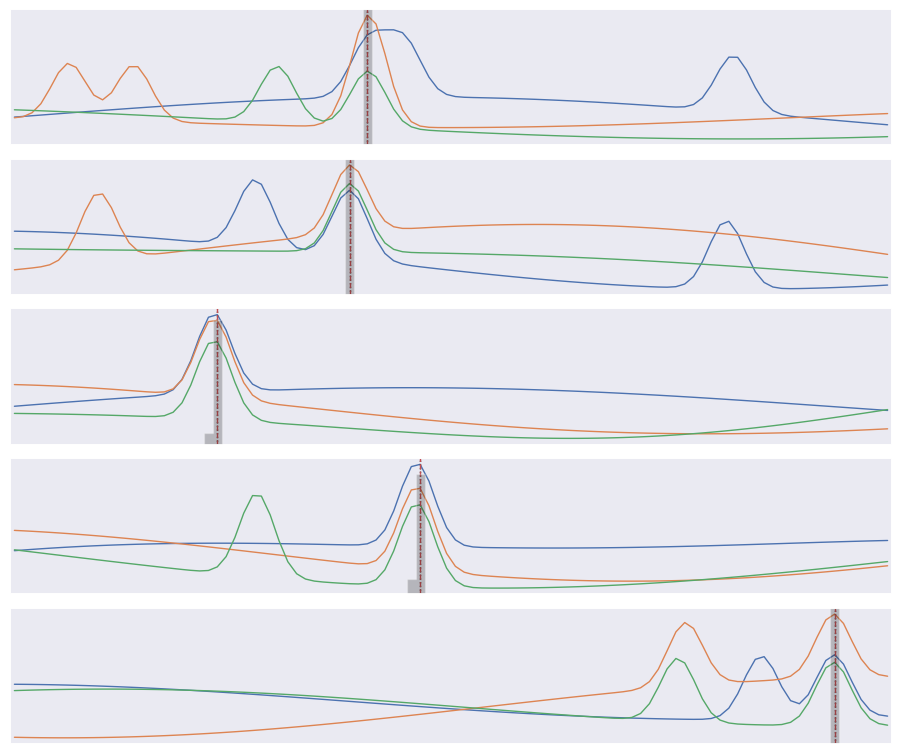

In [17]:
# Keras builder (similar to Estimator used in the original version)
def build_pulse_model(params):
    D   = params['time_steps']
    M   = params['number_of_traces']
    n1  = params['conv1_width']
    n2  = params['conv2_width']
    lr  = params.get('learning_rate', 1e-3)

    assert n1 % 2 == 1 and n2 % 2 == 1
    Lout   = D - n2 + 1
    offset = (n2 - 1) // 2

    inp = tf.keras.layers.Input(shape=(M, D, 1), name='X')

    # per-trace temporal features (1 x n1), SAME padding
    x = tf.keras.layers.Conv2D(filters=2, kernel_size=(1, n1), padding='same',
                 activation='tanh', name='conv1')(inp)

    # coincidence across traces (M x n2), VALID padding
    x = tf.keras.layers.Conv2D(filters=1, kernel_size=(M, n2), padding='valid',
                 activation=None, name='conv2')(x)  # (batch size, 1, Lout, 1)

    logits = tf.keras.layers.Reshape((Lout,), name='logits')(x)  # (batch size, Lout)
    model = tf.keras.Model(inp, logits, name='pulse_model')

    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='acc')]
        # , run_eagerly=True  # optional: handy for debugging
    )
    return model, offset, Lout

# Train/Evaluate
def train_eval(X, y, params, batch_size=500, steps=500, seed=123):
    tf.random.set_seed(seed); np.random.seed(seed)
    N, M, D = X.shape
    assert D == params['time_steps'] and M == params['number_of_traces']

    Xtr, Xte, ytr, yte = model_selection.train_test_split(
        X, y, test_size=0.4, random_state=seed
    )
    model, offset, Lout = build_pulse_model(params)

    # align labels to logits index space [0..Lout-1]
    ytr_adj = ytr - offset
    yte_adj = yte - offset

    steps_per_epoch = int(np.ceil(len(Xtr) / batch_size))
    epochs = int(np.ceil(steps / max(1, steps_per_epoch)))

    model.fit(Xtr[:,:,:, np.newaxis], ytr_adj, batch_size=batch_size, epochs=epochs, verbose=0)
    eval_dict = model.evaluate(Xte[:, :, :, np.newaxis], yte_adj, verbose=0, return_dict=True)
    return model, offset, eval_dict, (Xte, yte)

# Predict and plot
def plot_predictions(model, offset, X, y):
    import matplotlib.pyplot as plt
    Nsample, M, D = X.shape
    logits = model.predict(X[:,:,:, np.newaxis], verbose=0)
    probs_all = tf.nn.softmax(logits, axis=-1).numpy()

    t  = np.linspace(0., 1., D)
    dt = t[1] - t[0]
    bins = np.linspace(-0.5*dt, 1 + 0.5*dt, D + 1)

    _, ax = plt.subplots(Nsample, 1, figsize=(9, 1.5*Nsample))
    ax = np.atleast_1d(ax)

    for i in range(Nsample):
        pred_idx = probs_all[i].argmax() + offset  # map back to 0..D-1
        Lout = probs_all.shape[1]
        n2   = D - Lout + 1
        offset  = (n2 - 1) // 2

        probs = np.zeros(D, dtype=float)
        probs[offset:offset+Lout] = probs_all[i]

        for x in X[i]:
            ax[i].plot(t, x, lw=1)
        ax[i].axvline(t[y[i]],     c='k', ls=':',  lw=1)  # truth
        ax[i].axvline(t[pred_idx], c='r', ls='--', lw=1)  # prediction

        rhs = ax[i].twinx()
        rhs.hist(t, weights=probs, bins=bins, histtype='stepfilled', alpha=0.25, color='k')
        rhs.set_ylim(0., 1.); rhs.set_yticks([])
        ax[i].set_xlim(bins[0], bins[-1]); ax[i].set_xticks([]); ax[i].set_yticks([]); ax[i].grid(False)

    plt.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.99, hspace=0.1)

params = dict(
    time_steps=100,
    number_of_traces=3,
    conv1_width=3,
    conv2_width=7,
    learning_rate=0.01
)

model, offset, results, (X_test, y_test) = train_eval(X, y, params, batch_size=500, steps=500, seed=123)
print(results)   # e.g., {'loss': ..., 'acc': ...}
plot_predictions(model, offset, X_test[:5], y_test[:5])


Evaluate how well the trained network performs on the test data:

We find that about 95% of test samples are classified "correctly", defined as the network predicting the bin containing the the coincidence maximum exactly.  However, The RMS error between the predicted and true bins is only 0.4 bins, indicating that the network usually predicts a neighboring bin in the 5% of "incorrect" test cases.

In [18]:
results

{'acc': 0.9472500085830688, 'loss': 0.14754460752010345}

Finally, compare the predicted (gray histogram) and true (dotted line) coincidence locations for a few test samples:

Note that our loss function does not know that consecutive labels are close and being off by one is almost as good as getting the right label. We could change this by treating this as a regression problem, but a nice feature of our multi-category approach is that we can predict a a full probability density over labels (the gray histograms above) which is often useful.

## <span style="color:Orange">Acknowledgments</span>

* Initial version: Mark Neubauer (Updates: Aaron Pearlman)

© Copyright 2024